# Test hipy.cfit


## Extended curve_fit using strings

J. A. Hernando-Morata

05/04/2021


In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants

import warnings
warnings.filterwarnings('ignore')

In [3]:
import hipy.pltext as pltext
import hipy.utils  as ut
import hipy.cfit   as cfit
import hipy.efit   as efit

pltext.style()

## curve

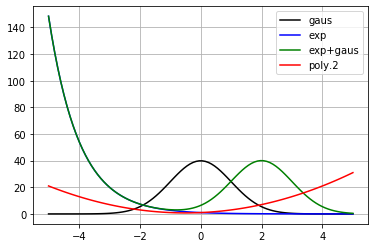

In [4]:
xs = np.linspace(-5, 5., 100)

names = ['gaus', 'exp', 'exp+gaus', 'poly.2']
pars  = ((100., 0., 1.), (1., 1.), (1., 1., 100., 2., 1.), (1., 1., 1.)) 

for name, par in zip(names, pars):
    cur = cfit.curve(name)
    plt.plot(xs, cur(xs, *par), label = name);
plt.legend(); plt.grid();

## curve_fit

In [5]:
def experiment(size, nbins, name,  pars0, mask = None, plot = False):

    is_composite = name.find('+') > 0
    size         = 1 if is_composite else size
    
    stat = efit.stat(name)
    rv   = stat.rvs(*pars0, size = size)
    
    y, edges = np.histogram(rv, nbins)
    x        = 0.5 *  (edges[1:] + edges[:-1])
    dx       = edges[1] - edges[0]
    ye       = np.maximum(2.4, np.sqrt(y))
    p0       = np.array(pars0) if is_composite else np.array((size * dx, *pars0))
    
    pars, upars, ffun = cfit.curve_fit(x, y, name, p0 = p0, sigma = ye, mask = mask)
    #try:
    #    pars, upars, ffun = cfit.curve_fit(x, y, name, p0 = p0, sigma = ye, mask = mask)
    #except:
    #    pars =  p0
    #    upars = np.ones(len(pars0))
   
    pulls        = (pars - p0)/upars
    if (plot):
        pltext.hist(rv, nbins)
        plt.plot(x, ffun(x))
        if (mask is not None): print('mask  ', mask) 
        print('p0    ', *p0)
        print('pars  ', *pars)
        print('unc   ', *upars)
        print('pulls ', *pulls)
    
    return pars, upars, pulls

def plt_pulls(res, name, mask = None):
    
    parnames = cfit.curve_argument_names(name)
    varnames = ['value', 'unc', 'pull']
    
    npars = len(res[0][0])
    
    subplot = pltext.canvas(npars * 3, 3)

    for i in range(npars):
        if ((mask is not None) and (mask[i] == False)): continue
        k = 3 * i
        for j in range(3):
            val = np.array([x[j][i] for x in res])
            #val = ut.remove_nan(val)
            if len(np.isfinite(val)) <= 0: continue
            val = val[np.isfinite(val)]
            subplot(k +  j + 1)
            pltext.hist(val, nbins)
            plt.xlabel(parnames[i] + ' ' + varnames[j])
    plt.tight_layout()

def test_pulls(nexp, size, nbins, name, pars0, mask = None):
        
    res = [experiment(size, nbins, name, pars0, mask) for i in range(nexp)]
    
    plt_pulls(res, name, mask)

### Gaus

p0     160.72940832810457 0.0 1.0
pars   154.10593167821153 0.034374947497938256 1.0054875437900657
unc    5.022623950627872 0.03417230612409986 0.028489433538137793
pulls  -1.3187283609128337 1.0059299882513777 0.19261680941180115


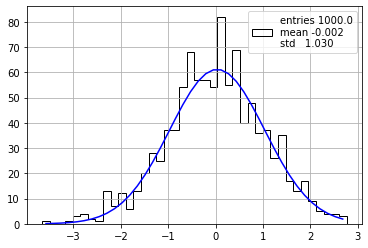

In [6]:
size, nbins  = 1000, 40
name, pars0   = 'normal', (0., 1.)
experiment(size, nbins, 'norm', pars0 = pars0, plot = True);

### Exponential

p0     1120.1654382658762 5.0
pars   220.33480167474582 5.049037385805365
unc    10.406494743562277 0.18565408319386498
pulls  -86.46817768757234 0.26413308536908725


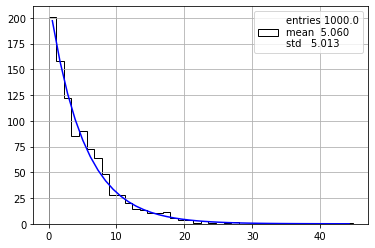

In [7]:
size, nbins  = 1000, 40
name, pars0  = 'exp', (5.,)

experiment(size, nbins, name, pars0, plot = True);

### Gamma

p0     141.78116974226074 5.0
pars   133.36962146163063 5.064099828985579
unc    4.473811620049472 0.07893253637671706
pulls  -1.880174892240344 0.8120837354022633


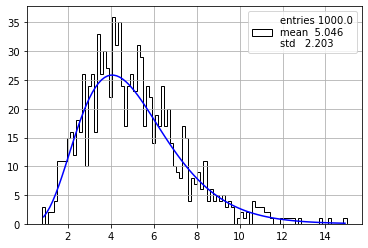

In [8]:
nexp, size, nbins = 500, 1000, 100
name, pars0       = 'gamma', (5.,)
experiment(size, nbins, name, pars0, plot = True);

### Gaus Exponential

p0     1000.0 1.0 500.0 5.0 1.0
pars   78.5420523744031 1.0318544265643397 39.60259114893185 4.940584483731886 1.0464125845826022
unc    4.212210579520684 0.0573498168987215 2.468426100532143 0.07132709762893448 0.06794305365320036
pulls  -218.7587562942904 0.5554407718614671 -186.5145603313041 -0.8330006160801865 0.683110076557709


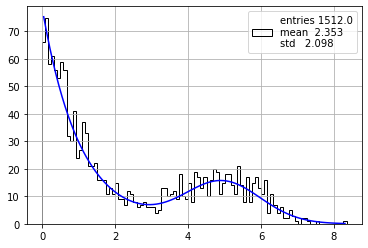

In [9]:
size, nbins  = 1000, 100
name, pars0  = 'exp+norm', (1000, 1., 500, 5, 1.)
experiment(size, nbins, name, pars0, plot = True);

## pulls

### Gaussian

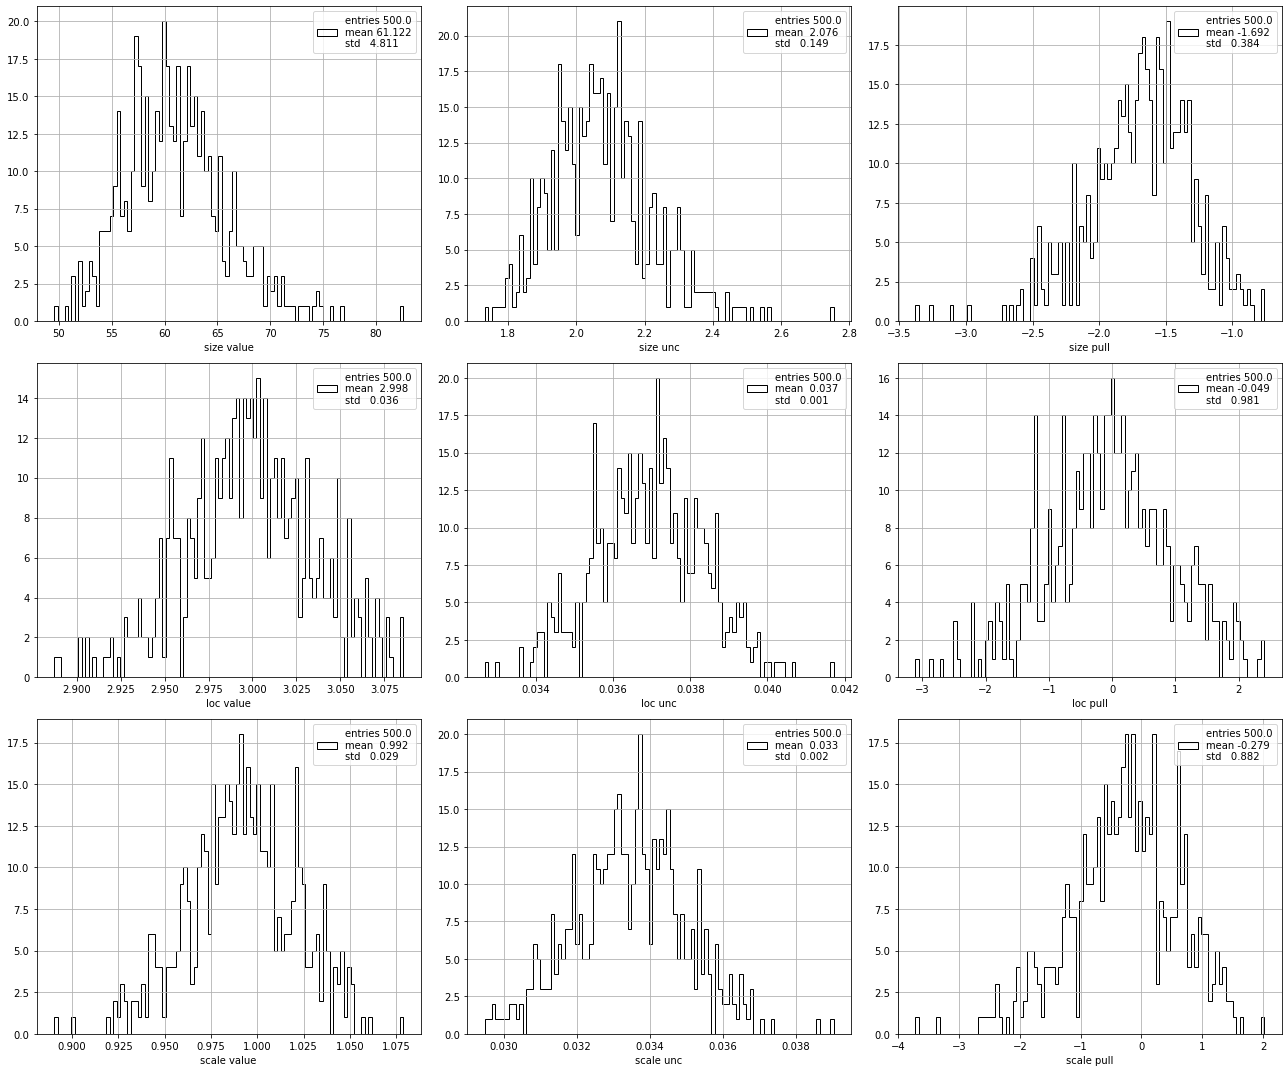

In [10]:
nexp, size, nbins = 500, 1000, 100
name, pars        = 'norm', (3., 1.)
test_pulls(nexp, size, nbins, name, pars)

### Exponential

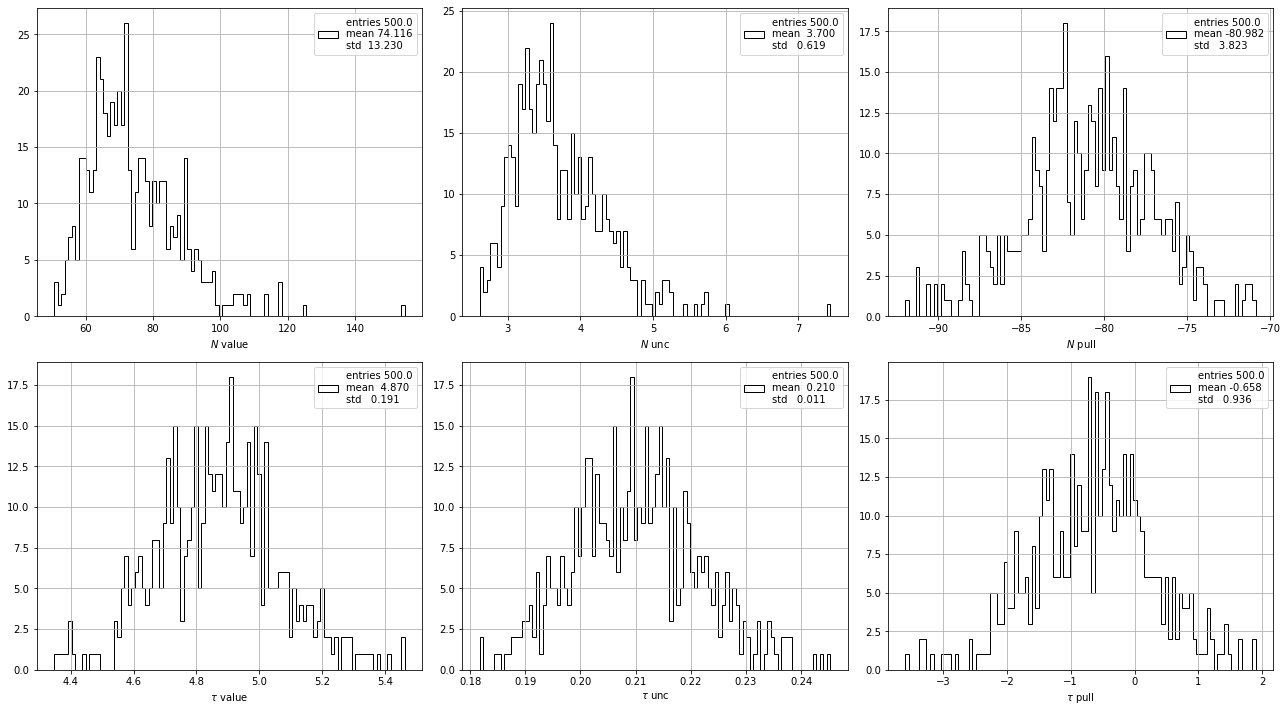

In [11]:
nexp, size, nbins = 500, 1000, 100
name, pars        = 'exp', (5.,)
test_pulls(nexp, size, nbins, name, pars)

### Gamma

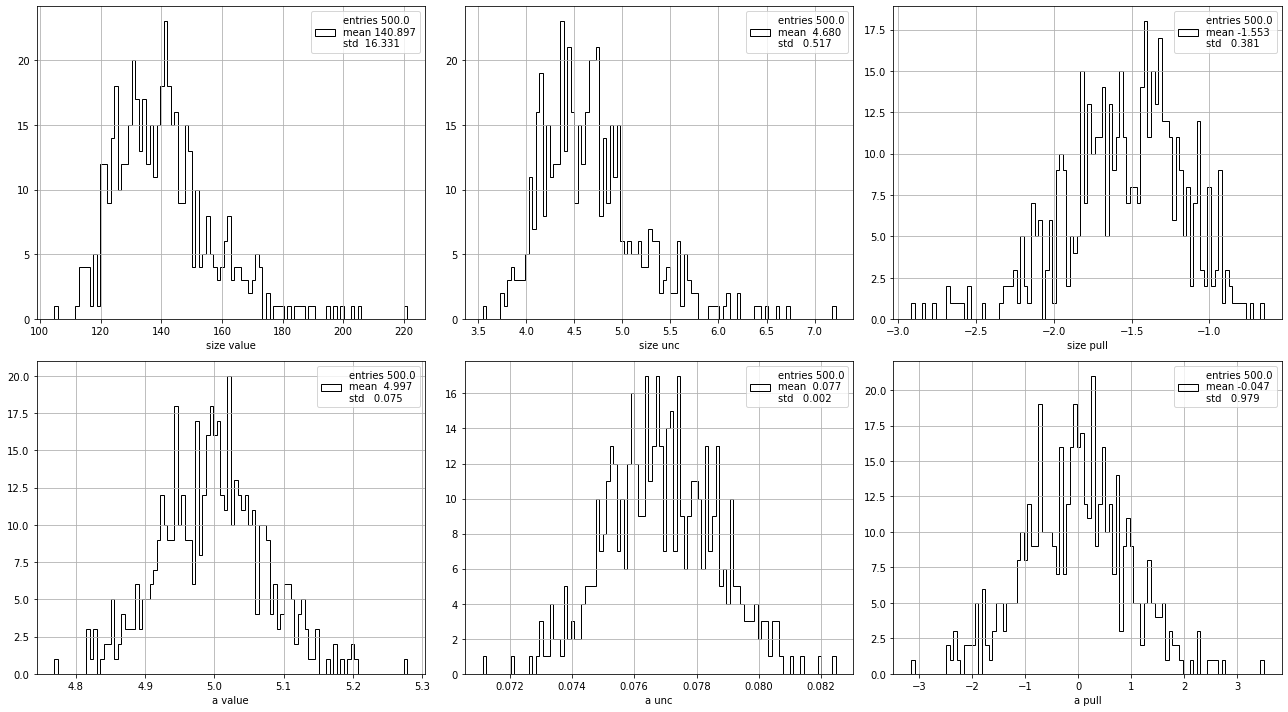

In [12]:
nexp, size, nbins = 500, 1000, 100
name, pars        = 'gamma', (5.,)
test_pulls(nexp, size, nbins, name, pars)

## Mask

### Gaussian

mask   (True, True, False)
p0     61.937492236917194 3.0 1.0
pars   58.368407915033735 2.9519417867536184 1.0
unc    1.948995282388959 0.03660408207439104 0.0
pulls  -1.8312431816195542 -1.312919503041004 nan


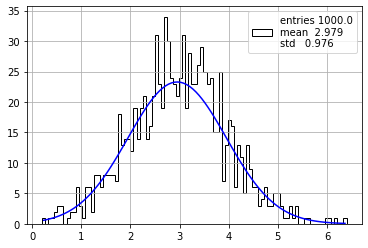

In [13]:
nexp, size, nbins = 500, 1000, 100
name, pars0      = 'norm', (3., 1.)
mask             = (True, True, False)
experiment(size, nbins, name, pars0, mask = mask, plot = True);

mask   (False, True, True)
p0     63.872992817917 3.0 1.0
pars   63.872992817917 2.9740586265012525 0.9914167538742991
unc    0.0 0.03441017967408411 0.030758797968903708
pulls  nan -0.7538866040355239 -0.279050115494707


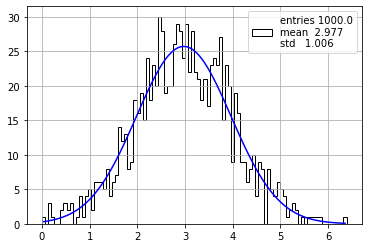

In [14]:
nexp, size, nbins = 500, 1000, 100
name, pars0      = 'norm', (3., 1.)
mask             = (False, True, True)
experiment(size, nbins, name, pars0, mask = mask, plot = True);

### Exponential + Norma

mask   (True, False, True, True, False)
p0     1000.0 1.0 500.0 5.0 1.0
pars   81.27761767446069 1.0 40.27694981080205 4.927427313087277 1.0
unc    2.701449416599301 0.0 1.9874910634919827 0.0598177848103281 0.0
pulls  -340.08498426080695 nan -231.30823510797254 -1.2132292618798695 nan


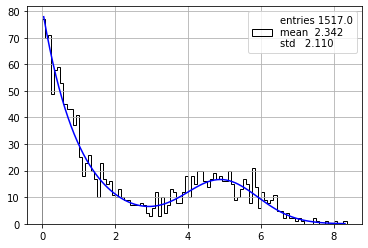

In [15]:
nexp, size, nbins = 500, 1000, 100
name, pars0      = 'exp+norm', (1000, 1, 500, 5., 1.)
mask             = (True, False, True, True, False)
experiment(size, nbins, name, pars0, mask = mask, plot = True);

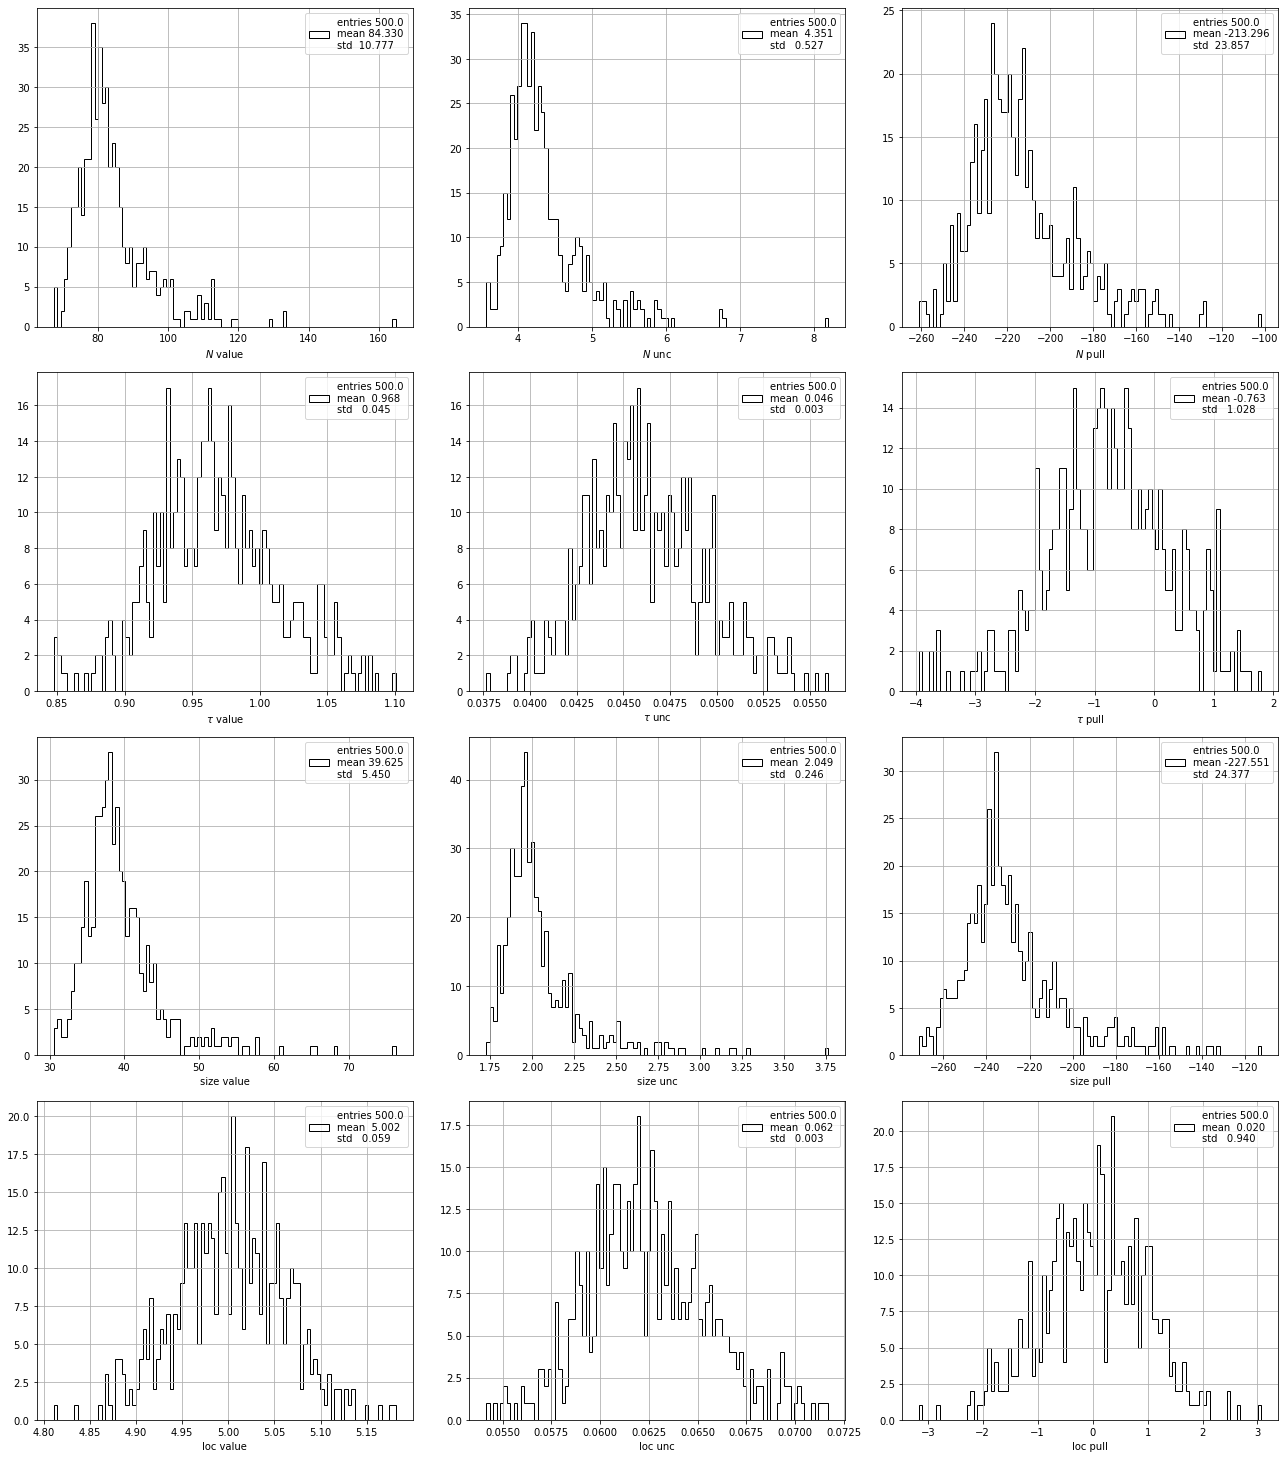

In [16]:
nexp, size, nbins = 500, 1000, 100
name, pars0      = 'exp+norm', (1000, 1, 500, 5., 1.)
mask             = (True, True, True, True, False)
test_pulls(nexp, size, nbins, name, pars0, mask = mask);